In [1]:
import networkx as nx
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
with open("data/comments_cleaned", 'rb') as file:
    data_comments = pickle.load(file)

In [3]:
with open("data/submissions_cleaned", 'rb') as file:
    data_submissions=pickle.load(file)

## SNet mreža ###

In [4]:
#pravimo jedinstvene sabredite da budu čvorovi
subs1=set(data_submissions['subreddit'].unique())
subs2=set(data_comments['subreddit'].unique())
data_subs=subs1.union(subs2)
print(len(data_subs))

4174


In [5]:
#graf i cvorovi
G=nx.Graph()
G.add_nodes_from(data_subs)

In [ ]:
print('Čvorovi:')
list(G.nodes())

In [7]:
#kako napraviti grane, ako svaka dva sabredita imaju korisnike aktivnih na tim sabreditima, pa racunamo za tezinu broj
#korisnika vezano za te sabredite, ako je autor jednog i drugog sabredita, to je tezina broj korisnika na jednom i drugom sabreditu
komentari=data_comments[['author','subreddit']].drop_duplicates()
objave=data_submissions[['author','subreddit']].drop_duplicates()
komObj=pd.merge(komentari, objave, how='outer', on=['subreddit','author'])
grupa=komObj.groupby('author')
sabrediti=grupa.apply(lambda x: x['subreddit'].unique())
sabrediti

author
*polhold00133                                                [reddit.com]
*polhold00149                                                   [science]
--------------------                  [politics, reddit.com, programming]
-----KATHRINE                                                [reddit.com]
--Aly95--                                                            [it]
                                              ...                        
zzzxxc                                                       [reddit.com]
zzzz2008                [politics, Libertarian, reddit.com, pics, Econ...
zzzz71                                                       [reddit.com]
zzzzzzzzzzz                                        [reddit.com, politics]
zzzzzzzzzzzzzzzzzzz                                          [reddit.com]
Length: 218731, dtype: object

In [8]:
for subreddits in sabrediti:
    for j in range(0, len(subreddits)):
        for k in range(j+1, len(subreddits)):
            #print(subreddits[j])
            #print(subreddits[k])
            subreddit1=subreddits[j]
            subreddit2=subreddits[k]
            if (subreddit1, subreddit2) in G.edges:
                G.edges[subreddit1, subreddit2]['weight'] += 1
            else:
                G.add_edge(subreddit1, subreddit2, weight=1)

In [ ]:
print(G.edges(['geek']))

In [9]:
print(G.edges['geek','reddit.com'])

{'weight': 3866}


In [11]:
kom1=komObj[komObj['subreddit']=='geek']
kom2=komObj[komObj['subreddit']=='reddit.com']
komIn=pd.merge(kom1, kom2, on=['author'], how='inner')
print(komIn) #ok je resenje

           author subreddit_x subreddit_y
0     OriginalSyn        geek  reddit.com
1           jmmcd        geek  reddit.com
2        mjsolaro        geek  reddit.com
3          MadAce        geek  reddit.com
4      astrosmash        geek  reddit.com
...           ...         ...         ...
3861      Fishbum        geek  reddit.com
3862   phillapier        geek  reddit.com
3863       Nurgle        geek  reddit.com
3864         nirk        geek  reddit.com
3865    dialector        geek  reddit.com

[3866 rows x 3 columns]


In [12]:
output_SNet = "models/undirected_count_aggregationSNET.gml"

nx.write_gml(G, output_SNet)

In [13]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4174
Number of edges: 135829
Average degree:  65.0834


## SNetF mreža ##

In [2]:
from collections import Counter
from operator import itemgetter

In [3]:
def raspodela_tezina(G):
    plt.figure(1)
    plt.xlabel('edge')  #edge
    plt.ylabel('weight') #weight
    xarray=[]
    yarray=[]
    i=1
    for node1, node2, weight in G.edges.data('weight'):
        xarray.append(i)
        yarray.append(weight)
        i=i+1
    plt.xlim(-1, max(xarray))
    plt.ylim(-1, max(yarray))
    plt.scatter(xarray, yarray, marker='.')
    plt.show()

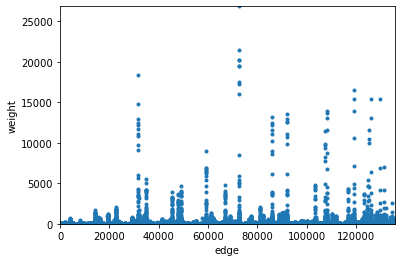

In [4]:
input_path = "models/undirected_count_aggregationSNET.gml" 
G = nx.Graph(nx.read_gml(input_path)) 

raspodela_tezina(G)

In [5]:
def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees) #raspakovanje
    deg_counts = Counter(deg_list)        
    print(deg_counts)
    x, y = zip(*deg_counts.items())     #x-stepen, y-broj cvorova koji imaju odredjeni stepen                                                 

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()

In [ ]:
plot_deg_frequency(G, True)

In [6]:
toRemove=[]
for a,b,weight in G.edges.data('weight'):
    if weight<=100:
        toRemove.append((a,b))
print(len(toRemove))

132657


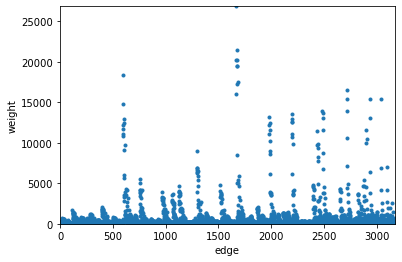

In [7]:
G.remove_edges_from(toRemove)
raspodela_tezina(G)

In [8]:
print(G.number_of_nodes())
print(G.number_of_edges())

4174
3172


In [ ]:
plot_deg_frequency(G, True)

In [10]:
output_SNetF = "models/undirected_count_aggregationSNetF.gml"
nx.write_gml(G, output_SNetF)

In [11]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 4174
Number of edges: 3172
Average degree:   1.5199


## SNetT mreža ##

In [16]:
chosen_subs={'reddit.com', 'pics', 'worldnews', 'programming','business', 'politics', 'obama', 'science',
             'technology', 'WTF', 'AskReddit', 'netsec', 'philosophy', 'videos', 'offbeat','funny', 'entertainment', 
             'linux', 'geek', 'gaming', 'comics', 'gadgets', 'nsfw', 'news', 'environment', 'atheism','canada', 
             'math', 'Economics','scifi', 'bestof', 'cogsci', 'joel', 'Health', 'guns', 'photography', 'software', 
             'history', 'ideas'}
print(list(chosen_subs))

['philosophy', 'business', 'obama', 'nsfw', 'ideas', 'netsec', 'pics', 'funny', 'joel', 'worldnews', 'videos', 'gadgets', 'photography', 'atheism', 'entertainment', 'AskReddit', 'software', 'guns', 'Health', 'linux', 'geek', 'cogsci', 'WTF', 'offbeat', 'gaming', 'science', 'math', 'scifi', 'environment', 'Economics', 'technology', 'history', 'news', 'comics', 'programming', 'bestof', 'politics', 'canada', 'reddit.com']


In [17]:
GT=G.subgraph(chosen_subs)

In [ ]:
GT.edges()

In [19]:
print(GT.edges['photography','scifi'])

{'weight': 189}


In [20]:
#provera
kom1=komObj[komObj['subreddit']=='photography']
kom2=komObj[komObj['subreddit']=='scifi']
komIn=pd.merge(kom1, kom2, on=['author'], how='inner')
print(komIn) #ok je resenje

           author  subreddit_x subreddit_y
0      finisterra  photography       scifi
1         stacy75  photography       scifi
2       kickstand  photography       scifi
3     wetelectric  photography       scifi
4         BeetleB  photography       scifi
..            ...          ...         ...
184      noname99  photography       scifi
185      MichDdot  photography       scifi
186  aaallleeexxx  photography       scifi
187         iwalk  photography       scifi
188        niki08  photography       scifi

[189 rows x 3 columns]


In [21]:
print(GT.edges['geek','reddit.com'])

{'weight': 3866}


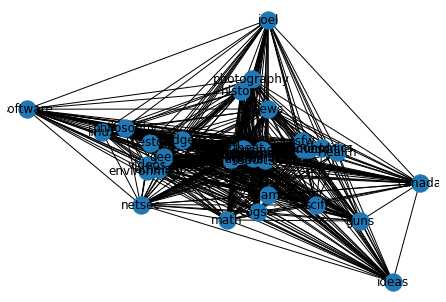

In [22]:
nx.draw(GT, with_labels=True)

In [ ]:
plt.figure(figsize=(20,15))
pos = nx.circular_layout(GT)
weight_edges=nx.get_edge_attributes(GT, 'weight')
nx.draw_networkx(GT, pos)
nx.draw_networkx_edge_labels(GT, pos, edge_labels=weight_edges)

In [24]:
print(nx.info(GT))

Name: 
Type: Graph
Number of nodes: 39
Number of edges: 741
Average degree:  38.0000


In [25]:
output_SNetT = "models/undirected_count_aggregationSNet_T.gml"

nx.write_gml(GT, output_SNetT)

## UserNet mreža ##

In [329]:
objaveRedit=data_submissions
komentariRedit=data_comments

In [330]:
#pravimo jedinstvene autore objava i komentara platforme 'Reddit' da budu čvorovi
users1=set(objaveRedit['author'].unique())
users2=set(komentariRedit['author'].unique())
data_users=users1.union(users2)
print(len(data_users))

218731


In [331]:
#graf i cvorovi
GUser=nx.DiGraph()
GUser.add_nodes_from(data_users)

In [ ]:
print('Čvorovi:')
list(GUser.nodes())

In [338]:
objaveRed=objaveRedit[['id','author']]
komentariRed=komentariRedit[['id','parent_id','author']]
komT1=komentariRed[komentariRed['parent_id'].str.startswith('t1_')] #oni koji pocinju sa t1_, to su komentari, a oni koji pocinju sa t3_, to su objave
objT3=komentariRed[komentariRed['parent_id'].str.startswith('t3_')] #sve je ok sa brojem komentara
#grupa=komT1.groupby('parent_id')
#korisnici=grupa.apply(lambda x: x['author'].unique())
#korisnici

In [ ]:
#print(objaveRed)
#print(objaveRed[objaveRed['id']=='7k8yt'])
#print(komentariRed)
#print(komT1)

In [340]:
#izvlacenje autora objave 'author_owner' (ako parent_id sadrzi t3_) na koju odredjeni korisnik komentarise
objT3.reset_index(drop=True, inplace=True)
#print(objT3)
idParObj=objT3['parent_id'].str.slice(3,)
#print(idParObj)
dataObjaveId=pd.DataFrame()
dataObjaveId['id']=idParObj
#print(dataObjaveId)
obj1=dataObjaveId.merge(objaveRed, how='left', on='id')
#print(obj1)
obj1.rename(columns = {'author':'author_owner'}, inplace = True)
obj1Aut=obj1['author_owner']
#print(obj1Aut)
objT3=objT3.join(obj1Aut)
print(objT3)

              id parent_id           author author_owner
0        c02s9t4  t3_648os  LiberalDemocrat       rmuser
1        c02s9u6  t3_648os        DiscoWolf       rmuser
2        c02s9uh  t3_648p5         Flemlord     Flemlord
3        c02s9us  t3_648p5  LiberalDemocrat     Flemlord
4        c02sa1z  t3_648p5        aletoledo     Flemlord
...          ...       ...              ...          ...
1476374  c06vwps  t3_7k8nj          pmn8441    homeworld
1476375  c06vwr2  t3_7k96e         aurora3d     aurora3d
1476376  c06vwrx  t3_79dot            yentz   forbishare
1476377  c06vwsf  t3_7k8na         clipmann  whisperthis
1476378  c06vwt7  t3_7k8z1          ENRICOs  neelakantha

[1476379 rows x 4 columns]


In [ ]:
print(objT3[40:100])

In [ ]:
print(objaveRedit[objaveRedit['id']=='648os']) #provera da li se poklapa sa vlasnikom objave na koju ukazuje komentar

In [341]:
#izvlacenje autora komentara 'author_owner' (ako parent_id sadrzi t1_) na koji odredjeni korisnik komentarise
komT1.reset_index(drop=True, inplace=True)
#print(objT3)
idParKom=komT1['parent_id'].str.slice(3,)
#print(idParObj)
dataKomId=pd.DataFrame()
dataKomId['id']=idParKom
#print(dataObjaveId)
kom1=dataKomId.merge(komentariRed, how='left', on='id')
#print(obj1)
kom1.rename(columns = {'author':'author_owner'}, inplace = True)
kom1Aut=kom1['author_owner']
#print(obj1Aut)
komT1=komT1.join(kom1Aut)
print(komT1)

              id   parent_id          author     author_owner
0        c02s9zh  t1_c02s9uh           dhpye         Flemlord
1        c02sc8z  t1_c02s9uh         boredzo         Flemlord
2        c02sa0a  t1_c02s9us  lemonjuicefake  LiberalDemocrat
3        c02sa8p  t1_c02s9us   LazarusDubois  LiberalDemocrat
4        c02sboz  t1_c02s9us      slamare247  LiberalDemocrat
...          ...         ...             ...              ...
1733062  c06vv9k  t1_c06vv4f        whichdan      noobprodigy
1733063  c06vwbf  t1_c06vviv     noobprodigy       spectorjay
1733064  c06vvys  t1_c06vvp9         Fabien3           stesch
1733065  c06vw4o  t1_c06vvp9          snissn           stesch
1733066  c06vw8z  t1_c06vvys          snissn          Fabien3

[1733067 rows x 4 columns]


In [ ]:
komT1=komT1.dropna()  #moramo jos cistiti
print(komT1[40:100])

In [353]:
print(komentariRedit[komentariRedit['id']=='c02s9us']) #provera da li se poklapa sa vlasnikom komentara na koji ukazuje komentar

        id           author   link_id parent_id  created_utc subreddit  \
6  c02s9us  LiberalDemocrat  t3_648p5  t3_648p5   1199146266  politics   

  subreddit_id  score distinguished  gilded  controversiality  
6     t5_2cneq    -10           NaN       0                 0  


In [ ]:
print(komT1[40:100]) #verzija gde imamo null vrednosti

In [107]:
#dataframovi gde smo sacuvali autore objava i komentara na koji su drugi odgovorili:
#objT3 i komT1

In [344]:
for _, _, _, kor1, kor2 in komT1.itertuples():
    if pd.isna(kor2): continue
    if (kor1, kor2) in GUser.edges:
        GUser.edges[kor1, kor2]['weight'] += 1
    else:
        GUser.add_edge(kor1, kor2, tip='komentar na komentar', weight=1)
for _, _, _, kor1, kor2 in objT3.itertuples():
    if pd.isna(kor2): continue
    if (kor1, kor2) in GUser.edges:
        GUser.edges[kor1, kor2]['weight'] += 1
    else:
        GUser.add_edge(kor1, kor2, tip='komentar na objavu', weight=1)

In [345]:
print(GUser.edges['SpiceMustFlow', 'jadecristal'])

{'tip': 'komentar na komentar', 'weight': 8}


In [346]:
print(GUser.edges['jadecristal','SpiceMustFlow'])

{'tip': 'komentar na komentar', 'weight': 6}


In [347]:
komOut=komT1[(komT1['author']=='SpiceMustFlow') & (komT1['author_owner']=='jadecristal')]
print(komOut) #ok je resenje

          id   parent_id         author author_owner
242  c02sbe8  t1_c02sbbx  SpiceMustFlow  jadecristal
243  c02sbto  t1_c02sbbx  SpiceMustFlow  jadecristal
245  c02sbg2  t1_c02sbfp  SpiceMustFlow  jadecristal
247  c02sblv  t1_c02sbhr  SpiceMustFlow  jadecristal
249  c02sbp3  t1_c02sbn4  SpiceMustFlow  jadecristal
251  c02sbwo  t1_c02sbuh  SpiceMustFlow  jadecristal
252  c02sbyt  t1_c02sbuh  SpiceMustFlow  jadecristal
254  c02sbze  t1_c02sbz3  SpiceMustFlow  jadecristal


In [348]:
komOut=komT1[(komT1['author']=='jadecristal') & (komT1['author_owner']=='SpiceMustFlow')]
print(komOut) #ok je resenje

          id   parent_id       author   author_owner
244  c02sbfp  t1_c02sbe8  jadecristal  SpiceMustFlow
246  c02sbhr  t1_c02sbg2  jadecristal  SpiceMustFlow
248  c02sbn4  t1_c02sblv  jadecristal  SpiceMustFlow
250  c02sbuh  t1_c02sbto  jadecristal  SpiceMustFlow
253  c02sbz3  t1_c02sbyt  jadecristal  SpiceMustFlow
255  c02sc0d  t1_c02sbze  jadecristal  SpiceMustFlow


In [349]:
print(GUser.edges['Thwart','andrewmg'])

{'tip': 'komentar na objavu', 'weight': 1}


In [350]:
objOut=objT3[(objT3['author']=='Thwart') & (objT3['author_owner']=='andrewmg')]
print(objOut) #ok je resenje

              id parent_id  author author_owner
1476366  c06vwlw  t3_7k8kt  Thwart     andrewmg


In [351]:
print(nx.info(GUser))

Name: 
Type: DiGraph
Number of nodes: 218731
Number of edges: 2377528
Average in degree:  10.8696
Average out degree:  10.8696


In [354]:
output_UserNet = "models/directed_count_aggregationUserNet.gml"
nx.write_gml(GUser, output_UserNet)